In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


# Validate COVID-19 Diagnosis ConVit model with another dataset

In [2]:
!pip -q install timm

     |████████████████████████████████| 376 kB 5.4 MB/s 


In [3]:
from __future__ import print_function

import glob
from itertools import chain
import time
import os
import random
import zipfile
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import timm

%config InlineBackend.figure_format = 'retina'

In [4]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


In [5]:
# Training settings
batch_size = 32
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [8]:
import torchvision
from torchvision.transforms import ToTensor

test_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset', transform=TRANSFORM_IMG)

In [9]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(len(test_data), len(test_loader))

746 24


## Effecient Attention

### Visual Transformer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('/content/gdrive/MyDrive/models/convit_model_pretrained.pt')  # Load from drive, not from above, skip this cell if load from above
model.eval()

ConViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 432, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((432,), eps=1e-06, elementwise_affine=True)
      (attn): GPSA(
        (qk): Linear(in_features=432, out_features=864, bias=False)
        (v): Linear(in_features=432, out_features=432, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=432, out_features=432, bias=True)
        (pos_proj): Linear(in_features=3, out_features=9, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((432,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=432, out_features=1728, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1728, out_features=432, bias=True)
        (drop): Dropout(p=0.0, inplac

# Testing

In [12]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/24 [00:00<?, ?it/s]

Evaluation completed in 1m 38s


In [13]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.5160857908847185
Overall F1: 0.4983541813711196
Overall Loss: 16.71390863205561


In [14]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.48837209 0.57826087]
recall: [0.72206304 0.33501259]
fscore: [0.58265896 0.42424242]
support: [349 397]


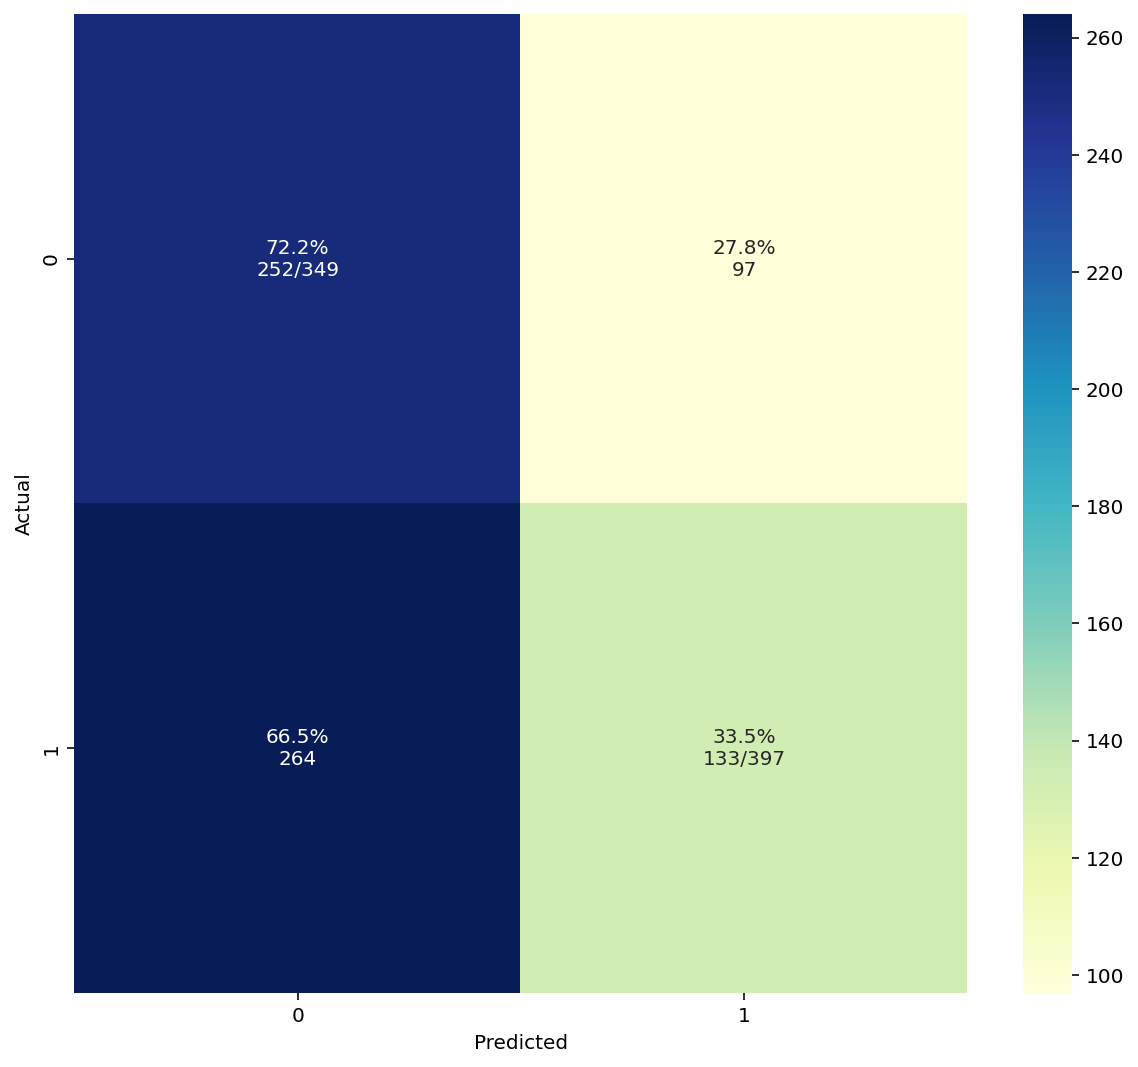

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

COVID-19 Positive


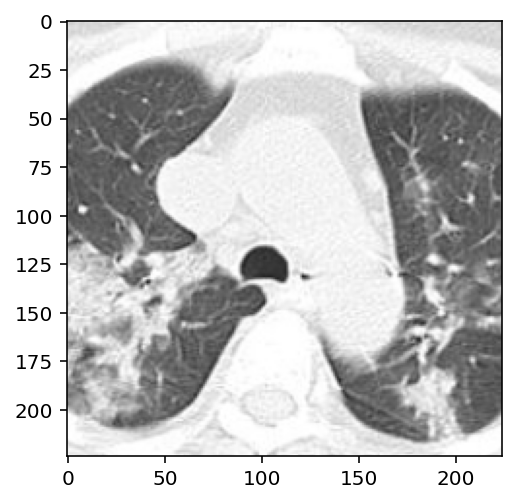

In [16]:
with torch.no_grad():
  def image_loader(image_name):
      """load image, returns cuda tensor"""
      image = Image.open(image_name)
      image = TRANSFORM_IMG(image).float()
      image = Variable(image, requires_grad=True)
      image1 = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
      return image1.cuda(), image  #assumes that you're using GPU

  image1, image2 = image_loader("/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset/COVID/2020.02.22.20024927-p19-68%3.png")

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

COVID-19 Positive


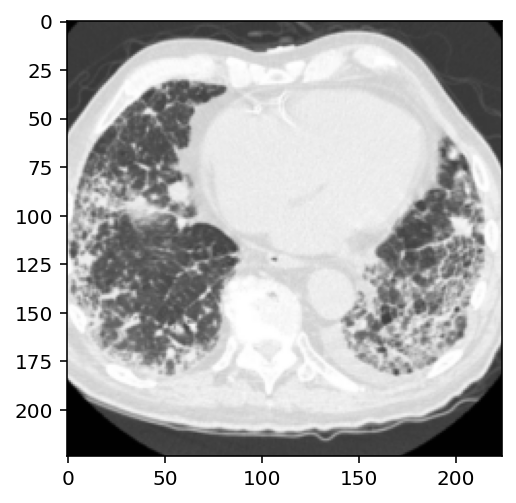

In [17]:
image1, image2 = image_loader("/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset/non-COVID/849.png")

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

In [18]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [19]:
classes = ['Positive', 'Negative']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

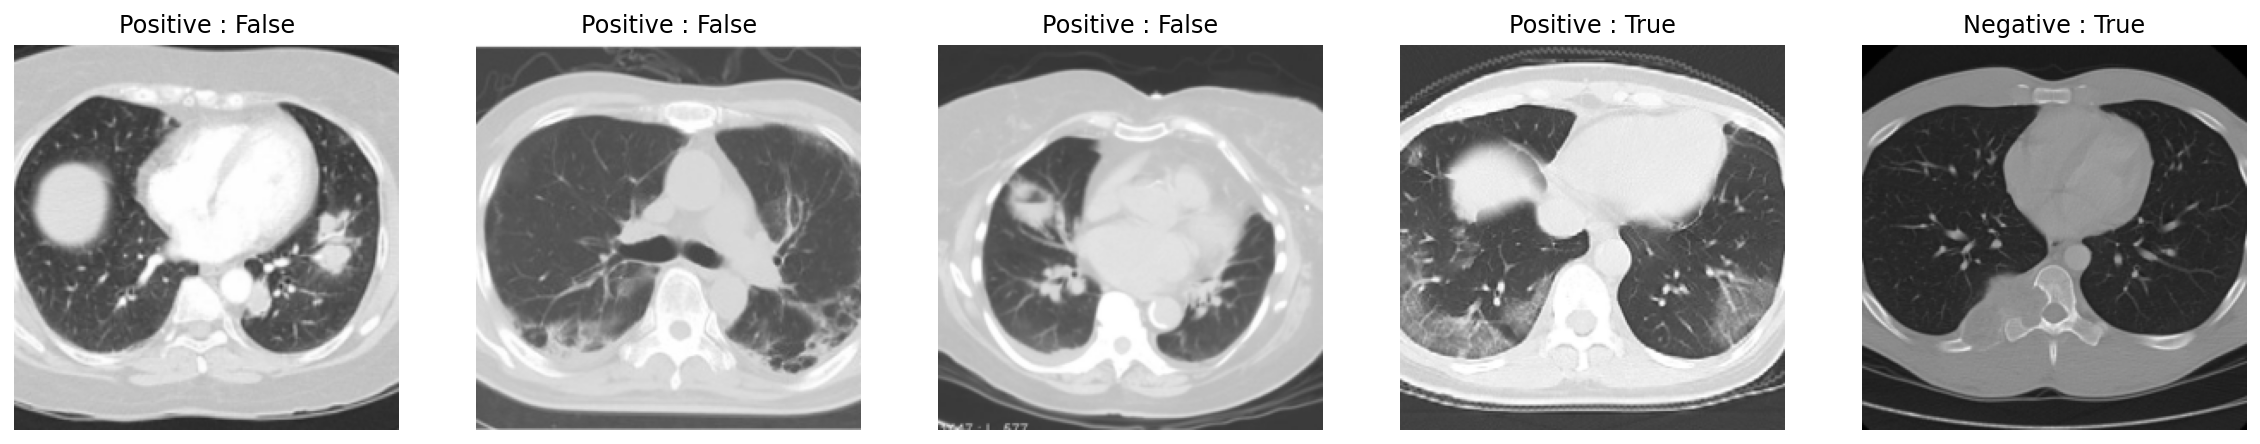

In [21]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()